In [2]:
#%%导入包

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import shap
import sklearn
#（边缘包）
import warnings
import streamlit as st
import pickle
import json

####（边缘函数）
from numpy import argmax
from functools import reduce
from io import StringIO
from collections import Counter
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler

###
from sklearn import svm, datasets,tree,linear_model,metrics
from sklearn.preprocessing import StandardScaler,label_binarize,OrdinalEncoder
from sklearn.ensemble import VotingClassifier,ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay,roc_auc_score,accuracy_score,roc_auc_score, roc_curve, auc,f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,KFold,cross_val_score,train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification,fetch_openml

###
import xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

%matplotlib inline
sns.set(style="darkgrid") #设置seaborn为暗黑风格

In [1]:
random_state_new = 50
jc = 10

In [3]:
import pandas as pd  
  
df = pd.read_csv('/home/gg/jupyter_notebook_wd/Radiomice/Untitled Folder/三合一.csv')  


#df1 = pd.read_csv('(PRJNA375935)~97+114.txt', sep='\t')
#df2 = pd.read_csv('(PRJEB28545)~113+37.txt', sep='\t')

In [4]:
# # 特征提取与转换
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=random_state_new)

In [5]:
df.columns[19:25]

Index(['wavelet-LLH_glszm_GrayLevelNonUniformity',
       'wavelet-LHL_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-HHH_glcm_ClusterShade',
       'wavelet-HHH_glszm_GrayLevelNonUniformityNormalized',
       'wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-HHH_glszm_ZoneVariance'],
      dtype='object')

In [7]:
target= 'survival'

X = df  # 移除目标变量
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state_new)

# 将 X_train 和 X_test 保存为 CSV 文件
X_train.to_csv("X_train.csv", index=False, encoding="utf-8-sig")
X_test.to_csv("X_test.csv", index=False, encoding="utf-8-sig")

print("X_train 和 X_test 已成功导出为 CSV 文件！")

X_train 和 X_test 已成功导出为 CSV 文件！


# 划分数据集

In [7]:
#特征标注
# features = ["wavelet.LLH_glszm_GrayLevelNonUniformity","wavelet.LHL_glszm_SizeZoneNonUniformityNormalized","wavelet.HHH_glcm_ClusterShade","wavelet.HHH_glszm_GrayLevelNonUniformityNormalized","wavelet.HHH_glszm_SizeZoneNonUniformityNormalized","wavelet.HHH_glszm_ZoneVariance" ]
target= 'survival'

X = df.iloc[:,19:25]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state_new)

#处理不平衡数据（重采样）
oversample = SMOTE(random_state=random_state_new)
# oversample = ADASYN()
X_train_rs, y_train_rs = oversample.fit_resample(X_train, y_train)
X_test_rs, y_test_rs = oversample.fit_resample(X_test, y_test)
# 查看原始数据集的类别分布
print('Original dataset shape:', Counter(y_train))
# 查看生成的合成样本后的类别分布
print('Resampled dataset shape:', Counter(y_train_rs))

# X = df1.iloc[:, 2:]
# y = df1.iloc[:, 1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state_new)

Original dataset shape: Counter({0: 47, 1: 33})
Resampled dataset shape: Counter({0: 47, 1: 47})


In [8]:
X_train = X_train_rs
y_train  = y_train_rs

# X_test = X_test_rs
# y_test  = y_test_rs

# 构建模型

In [9]:
#LR
logis_model = LogisticRegression(random_state=random_state_new,
                                 solver='lbfgs', multi_class='multinomial')
lr_model = logis_model.fit(X_train, y_train)
lr_model_y_prob = lr_model.predict_proba(X_test)

#MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='constant',
                    learning_rate_init=1,
                    power_t=0.5,
                    max_iter=200,
                    shuffle=True, random_state=random_state_new)
mlp_model = mlp_model.fit(X_train, y_train)
mlp_model_y_prob = mlp_model.predict_proba(X_test)

#NBC
NBC_model = GaussianNB(var_smoothing=1e-1)
#from sklearn.naive_bayes import BernoulliNB
#model = BernoulliNB()
NBC_model = NBC_model.fit(X_train, y_train)
NBC_model_y_prob = NBC_model.predict_proba(X_test)

#SVC
SVC_model = SVC(kernel='rbf',C=1.0,random_state=random_state_new,probability=True)
SVC_model = SVC_model.fit(X_train, y_train)
SVC_model_y_prob = SVC_model.predict_proba(X_test)

#XGB
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=2, learning_rate=1, random_state=random_state_new)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_model_y_prob = xgb_model.predict_proba(X_test)

#BAG
Bag = BaggingClassifier(KNeighborsClassifier(),
                        max_samples=0.5, max_features=0.5, random_state=random_state_new)
Bag_model = Bag.fit(X_train, y_train)
Bag_model_y_prob = Bag_model.predict_proba(X_test)

#AB
AB = AdaBoostClassifier(n_estimators=10, random_state=random_state_new)
AB_model = AB.fit(X_train, y_train)
AB_model_y_prob = AB_model.predict_proba(X_test)

#GBM
gbm = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1, max_depth=1, random_state=random_state_new)
gbm_model = gbm.fit(X_train, y_train)
gbm_model_y_prob = gbm_model.predict_proba(X_test)

#RF
RF_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=random_state_new)
RF_model = RF_model.fit(X_train, y_train)
RF_model_y_prob = RF_model.predict_proba(X_test)




/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-pa

# 训练集的十折交叉验证曲线

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

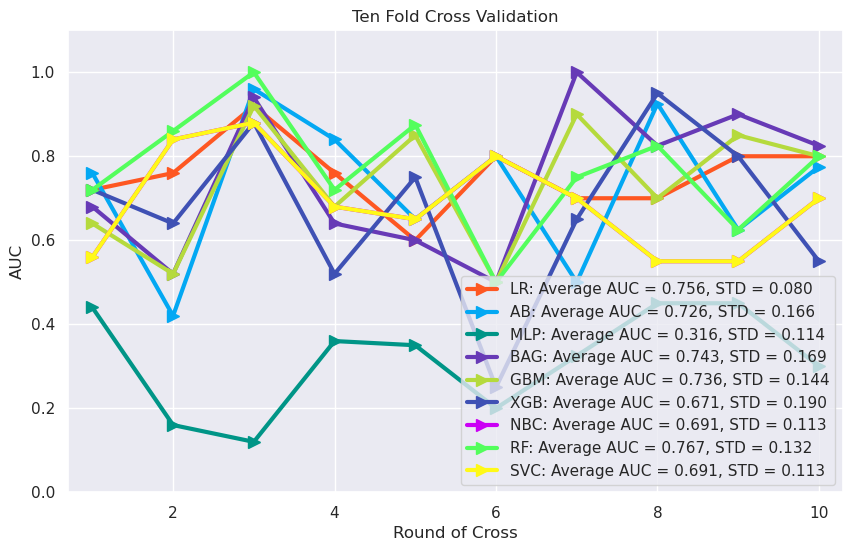

In [24]:
k_folds = 10
strKFold = StratifiedKFold(n_splits=k_folds,shuffle=True,random_state=0)#, test_size=.3)
cv=strKFold

result_lr=cross_val_score(lr_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_ab=cross_val_score(AB_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_bag=cross_val_score(Bag_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_mlp=cross_val_score(mlp_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_gbm=cross_val_score(gbm_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_xgb=cross_val_score(xgb_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)

result_nbc=cross_val_score(NBC_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_rf=cross_val_score(RF_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_svc=cross_val_score(SVC_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)

sns.set()
x = [1, 2, 3, 4, 5,6,7,8,9,10]
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
plt.plot(x, result_lr, label='LR: Average AUC = {:.3f}, STD = {:.3f}'.format(result_lr.mean(), result_lr.std()),
         linewidth=3, color='#fe5722', marker='>', markerfacecolor='#fe5722', markersize=8)
plt.plot(x, result_ab, label='AB: Average AUC = {:.3f}, STD = {:.3f}'.format(result_ab.mean(), result_ab.std()),
         linewidth=3, color='#03a8f3', marker='>', markerfacecolor='#03a8f3', markersize=8)
plt.plot(x, result_mlp, label='MLP: Average AUC = {:.3f}, STD = {:.3f}'.format(result_mlp.mean(), result_mlp.std()),
         linewidth=3, color='#009587', marker='>', markerfacecolor='#009587', markersize=8)
plt.plot(x, result_bag, label='BAG: Average AUC = {:.3f}, STD = {:.3f}'.format(result_bag.mean(), result_bag.std()),
         linewidth=3, color='#673ab6', marker='>', markerfacecolor='#673ab6', markersize=8)
plt.plot(x, result_gbm, label='GBM: Average AUC = {:.3f}, STD = {:.3f}'.format(result_gbm.mean(), result_gbm.std()),
         linewidth=3, color='#b5da3d', marker='>', markerfacecolor='#b5da3d', markersize=8)
plt.plot(x, result_xgb, label='XGB: Average AUC = {:.3f}, STD = {:.3f}'.format(result_xgb.mean(), result_xgb.std()),
         linewidth=3, color='#3f51b4', marker='>', markerfacecolor='#3f51b4', markersize=8)

plt.plot(x, result_nbc, label='NBC: Average AUC = {:.3f}, STD = {:.3f}'.format(result_nbc.mean(), result_nbc.std()),
         linewidth=3, color='#cb00f5', marker='>', markerfacecolor='#cb00f5', markersize=8)
plt.plot(x, result_rf, label='RF: Average AUC = {:.3f}, STD = {:.3f}'.format(result_rf.mean(), result_rf.std()),
         linewidth=3, color='#53fe5c', marker='>', markerfacecolor='#53fe5c', markersize=8)
plt.plot(x, result_svc, label='SVC: Average AUC = {:.3f}, STD = {:.3f}'.format(result_svc.mean(), result_svc.std()),
         linewidth=3, color='#fff917', marker='>', markerfacecolor='#fff917', markersize=8)

ax = plt.gca()
plt.ylim(0.0, 1.1)
plt.xlim(0.7, 10.3)
plt.xlabel('Round of Cross')
plt.ylabel('AUC')
plt.title('Ten Fold Cross Validation')
plt.legend(loc=4)
# plt.show()

plt.savefig("01.TR-十折交叉验证.pdf",format='pdf')
plt.show()

# 训练集和测试集的ROC曲线

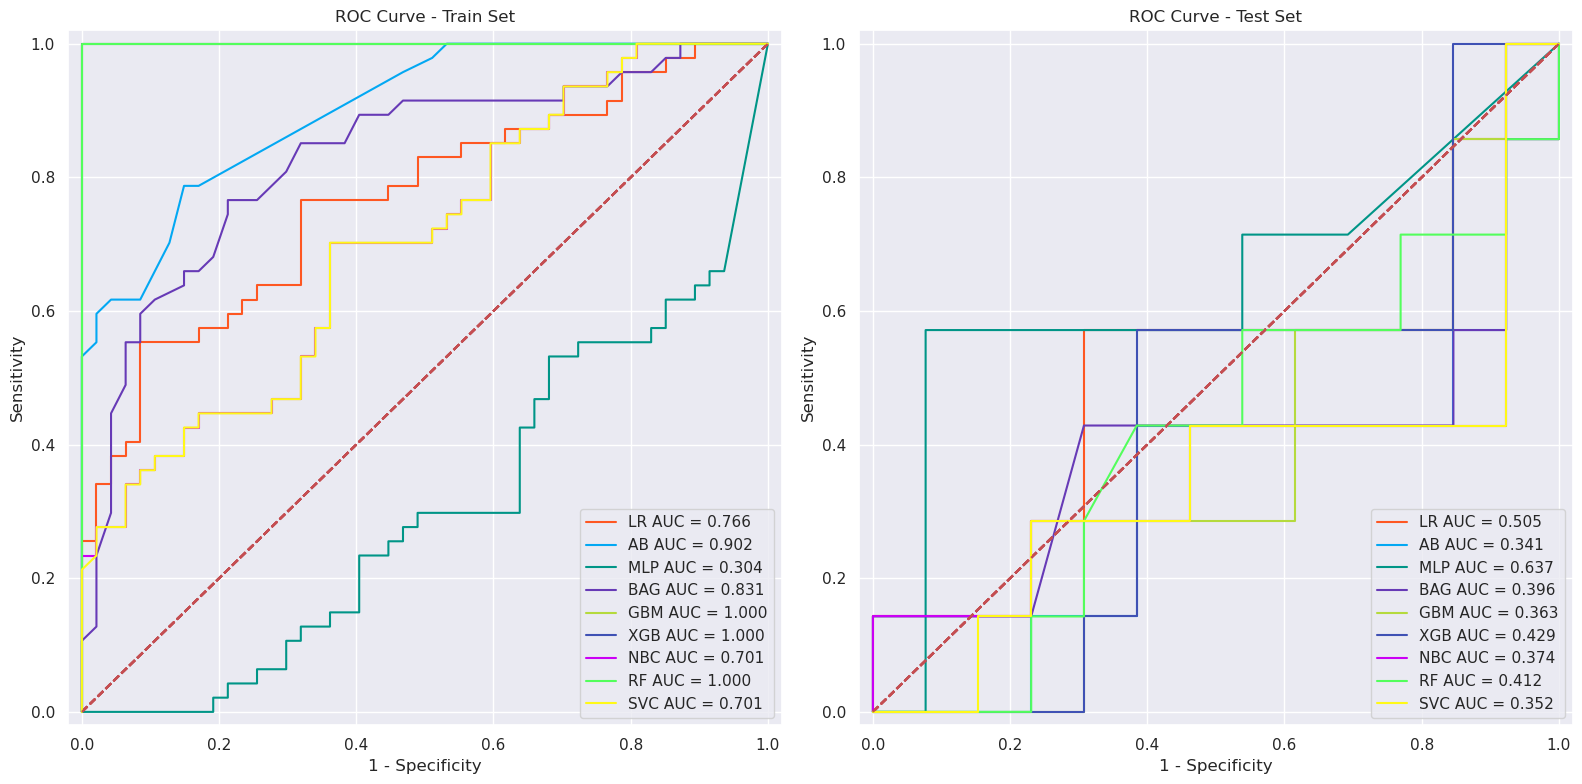

In [14]:
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

plt.style.use('tableau-colorblind10')

def plot_roc(ax, y_pred_score, labels_test, classifier, color):
    """Plots ROC curve on the given axis"""
    fpr, tpr, _ = metrics.roc_curve(labels_test.values.ravel(), y_pred_score)
    roc_auc = metrics.auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=color, label=f'{classifier} AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_ylabel('Sensitivity')
    ax.set_xlabel('1 - Specificity')
    ax.legend(loc='lower right')

# Set up figure size
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Create one figure with two subplots

# Plot for train set (left subplot)
axes[0].set_title('ROC Curve - Train Set')
plot_roc(axes[0], lr_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'LR', '#fe5722')
plot_roc(axes[0], AB_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'AB', '#03a8f3')
plot_roc(axes[0], mlp_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'MLP', '#009587')
plot_roc(axes[0], Bag_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'BAG', '#673ab6')
plot_roc(axes[0], gbm_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'GBM', '#b5da3d')
plot_roc(axes[0], xgb_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'XGB', '#3f51b4')
plot_roc(axes[0], NBC_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'NBC', '#cb00f5')
plot_roc(axes[0], RF_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'RF', '#53fe5c')
plot_roc(axes[0], SVC_model.predict_proba(X_train)[:, 1], pd.DataFrame(y_train), 'SVC', '#fff917')

# Plot for test set (right subplot)
axes[1].set_title('ROC Curve - Test Set')
plot_roc(axes[1], lr_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'LR', '#fe5722')
plot_roc(axes[1], AB_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'AB', '#03a8f3')
plot_roc(axes[1], mlp_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'MLP', '#009587')
plot_roc(axes[1], Bag_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'BAG', '#673ab6')
plot_roc(axes[1], gbm_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'GBM', '#b5da3d')
plot_roc(axes[1], xgb_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'XGB', '#3f51b4')
plot_roc(axes[1], NBC_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'NBC', '#cb00f5')
plot_roc(axes[1], RF_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'RF', '#53fe5c')
plot_roc(axes[1], SVC_model.predict_proba(X_test)[:, 1], pd.DataFrame(y_test), 'SVC', '#fff917')

# Save and display the plot
plt.tight_layout()
plt.savefig("训练集-测试集ROC曲线.pdf", format="pdf")
plt.show()


# 训练集-测试集PR曲线

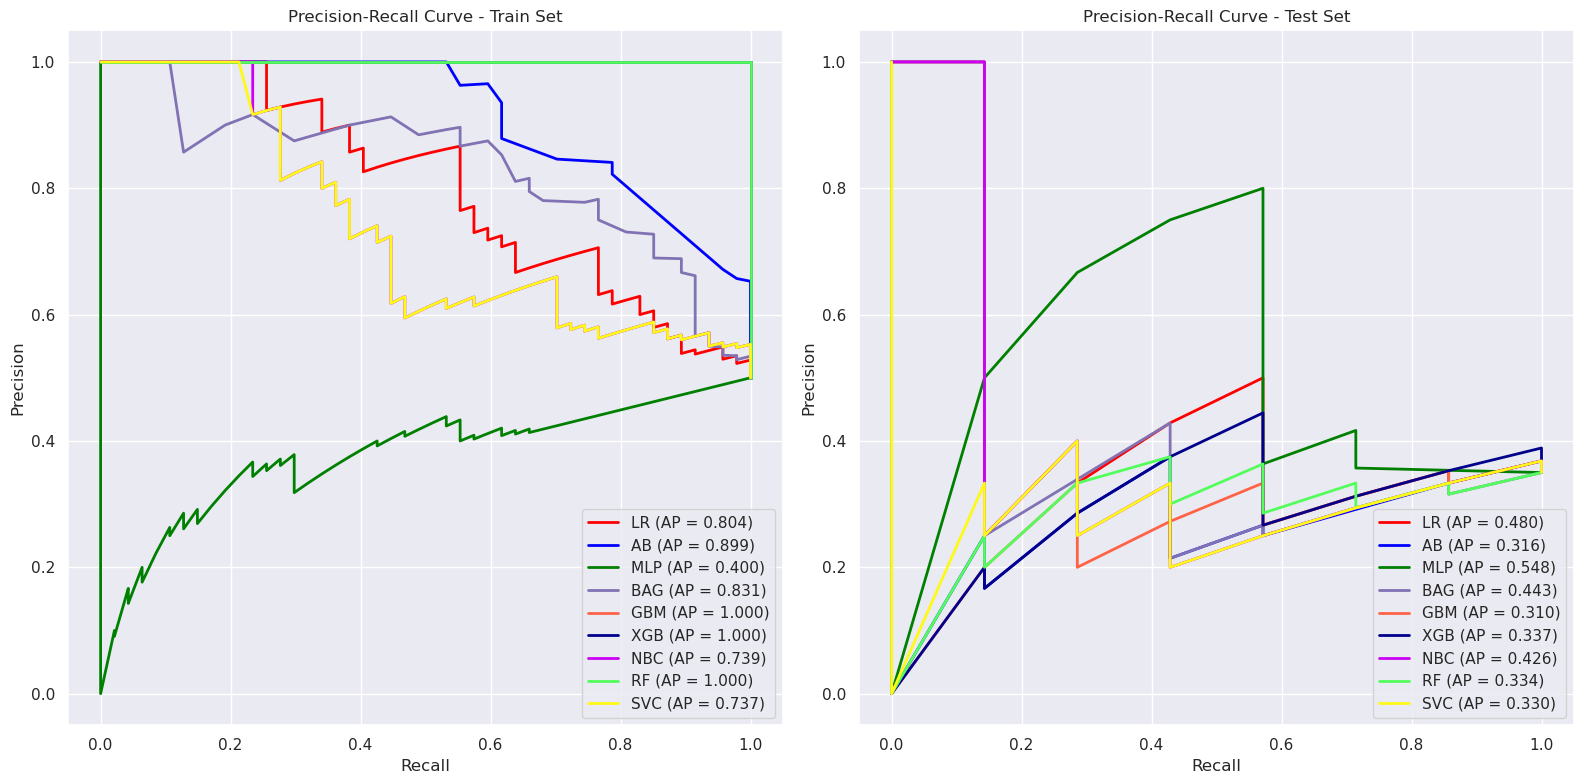

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import pandas as pd

plt.style.use('tableau-colorblind10')

def pr_curve(ax, y_pred, y_label, method_name, color):
    """Plots Precision-Recall curve on the given axis"""
    y_label = np.array(y_label)
    y_pred = np.array(y_pred)
    
    precision, recall, _ = precision_recall_curve(y_label, y_pred)
    ap_score = average_precision_score(y_label, y_pred)
    
    ax.plot(recall, precision, lw=2, label=f'{method_name} (AP = {ap_score:.3f})', color=color)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='lower right')

# Create figure with two subplots (Train and Test)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot PR curves for Train Set (Left subplot)
axes[0].set_title('Precision-Recall Curve - Train Set')
pr_curve(axes[0], lr_model.predict_proba(X_train)[:, 1], y_train, 'LR', 'red')
pr_curve(axes[0], AB_model.predict_proba(X_train)[:, 1], y_train, 'AB', 'blue')
pr_curve(axes[0], mlp_model.predict_proba(X_train)[:, 1], y_train, 'MLP', 'green')
pr_curve(axes[0], Bag_model.predict_proba(X_train)[:, 1], y_train, 'BAG', 'm')
pr_curve(axes[0], gbm_model.predict_proba(X_train)[:, 1], y_train, 'GBM', 'tomato')
pr_curve(axes[0], xgb_model.predict_proba(X_train)[:, 1], y_train, 'XGB', 'darkblue')
pr_curve(axes[0], NBC_model.predict_proba(X_train)[:, 1], y_train, 'NBC', '#cb00f5')
pr_curve(axes[0], RF_model.predict_proba(X_train)[:, 1], y_train, 'RF', '#53fe5c')
pr_curve(axes[0], SVC_model.predict_proba(X_train)[:, 1], y_train, 'SVC', '#fff917')

# Plot PR curves for Test Set (Right subplot)
axes[1].set_title('Precision-Recall Curve - Test Set')
pr_curve(axes[1], lr_model.predict_proba(X_test)[:, 1], y_test, 'LR', 'red')
pr_curve(axes[1], AB_model.predict_proba(X_test)[:, 1], y_test, 'AB', 'blue')
pr_curve(axes[1], mlp_model.predict_proba(X_test)[:, 1], y_test, 'MLP', 'green')
pr_curve(axes[1], Bag_model.predict_proba(X_test)[:, 1], y_test, 'BAG', 'm')
pr_curve(axes[1], gbm_model.predict_proba(X_test)[:, 1], y_test, 'GBM', 'tomato')
pr_curve(axes[1], xgb_model.predict_proba(X_test)[:, 1], y_test, 'XGB', 'darkblue')
pr_curve(axes[1], NBC_model.predict_proba(X_test)[:, 1], y_test, 'NBC', '#cb00f5')
pr_curve(axes[1], RF_model.predict_proba(X_test)[:, 1], y_test, 'RF', '#53fe5c')
pr_curve(axes[1], SVC_model.predict_proba(X_test)[:, 1], y_test, 'SVC', '#fff917')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("训练集-测试集PR曲线.pdf", format="pdf")
plt.show()


# 训练集-测试集校准曲线

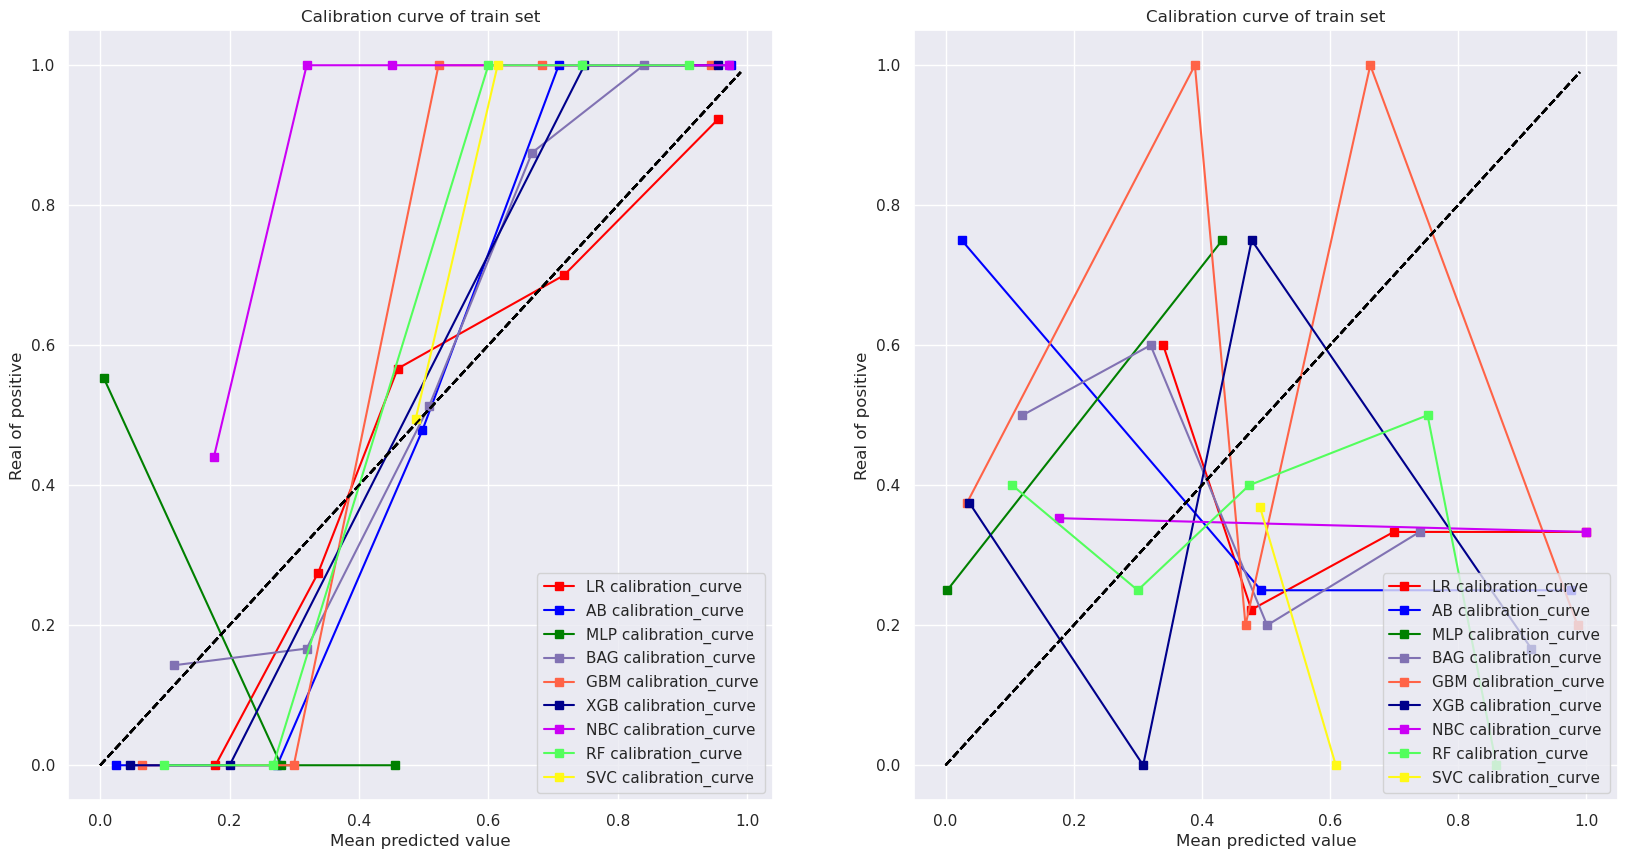

In [16]:
lr_prob = logis_model.predict(X_test)
ab_prob = AB_model.predict(X_test)
mlp_prob = mlp_model.predict(X_test)
bag_prob = Bag_model.predict(X_test)
gbm_prob = gbm_model.predict(X_test)
xgb_prob = xgb_model.predict(X_test)

nbc_prob=NBC_model.predict(X_test)
rf_prob=RF_model.predict(X_test)
svc_prob=SVC_model.predict(X_test)

plt.rcParams["axes.grid"] = False
sns.set()
from sklearn.calibration import calibration_curve
def calibration_curve_1(k,y_pred,y_true,method_name,color,title):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=5)
    plt.figure(k)
    plt.plot(prob_pred,prob_true,color=color,label='%s calibration_curve'%method_name,marker='s')
    plt.plot([i/100 for i in range(0,100)],[i/100 for i in range(0,100)],color='black',linestyle='--')
    #plt.xlim(-0.02,1.02,0.2)
    #plt.ylim(-0.02,1.02,0.2)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Real of positive')
    plt.title(title)
    plt.legend(loc='lower right')

plt.rcParams["figure.figsize"] = [20, 10]

plt.subplot(1,2,1)
calibration_curve_1(1,lr_model.predict_proba(X_train)[:,1],y_train,'LR','red','Calibration curve of train set')
calibration_curve_1(1,AB_model.predict_proba(X_train)[:,1],y_train,'AB','blue','Calibration curve of train set')
calibration_curve_1(1,mlp_model.predict_proba(X_train)[:,1],y_train,'MLP','green','Calibration curve of train set')
calibration_curve_1(1,Bag_model.predict_proba(X_train)[:,1],y_train,'BAG','m','Calibration curve of train set')
calibration_curve_1(1,gbm_model.predict_proba(X_train)[:,1],y_train,'GBM','tomato','Calibration curve of train set')
calibration_curve_1(1,xgb_model.predict_proba(X_train)[:,1],y_train,'XGB','darkblue','Calibration curve of train set')

calibration_curve_1(1,NBC_model.predict_proba(X_train)[:,1],y_train,'NBC','#cb00f5','Calibration curve of train set')
calibration_curve_1(1,RF_model.predict_proba(X_train)[:,1],y_train,'RF','#53fe5c','Calibration curve of train set')
calibration_curve_1(1,SVC_model.predict_proba(X_train)[:,1],y_train,'SVC','#fff917','Calibration curve of train set')


plt.subplot(1,2,2)
calibration_curve_1(1,lr_model.predict_proba(X_test)[:,1],y_test,'LR','red','Calibration curve of test set')
calibration_curve_1(1,AB_model.predict_proba(X_test)[:,1],y_test,'AB','blue','Calibration curve of test set')
calibration_curve_1(1,mlp_model.predict_proba(X_test)[:,1],y_test,'MLP','green','Calibration curve of test set')
calibration_curve_1(1,Bag_model.predict_proba(X_test)[:,1],y_test,'BAG','m','Calibration curve of test set')
calibration_curve_1(1,gbm_model.predict_proba(X_test)[:,1],y_test,'GBM','tomato','Calibration curve of test set')
calibration_curve_1(1,xgb_model.predict_proba(X_test)[:,1],y_test,'XGB','darkblue','Calibration curve of test set')

calibration_curve_1(1,NBC_model.predict_proba(X_test)[:,1],y_test,'NBC','#cb00f5','Calibration curve of train set')
calibration_curve_1(1,RF_model.predict_proba(X_test)[:,1],y_test,'RF','#53fe5c','Calibration curve of train set')
calibration_curve_1(1,SVC_model.predict_proba(X_test)[:,1],y_test,'SVC','#fff917','Calibration curve of train set')


plt.savefig("训练集-测试集校准曲线.pdf", format="pdf")
plt.show()

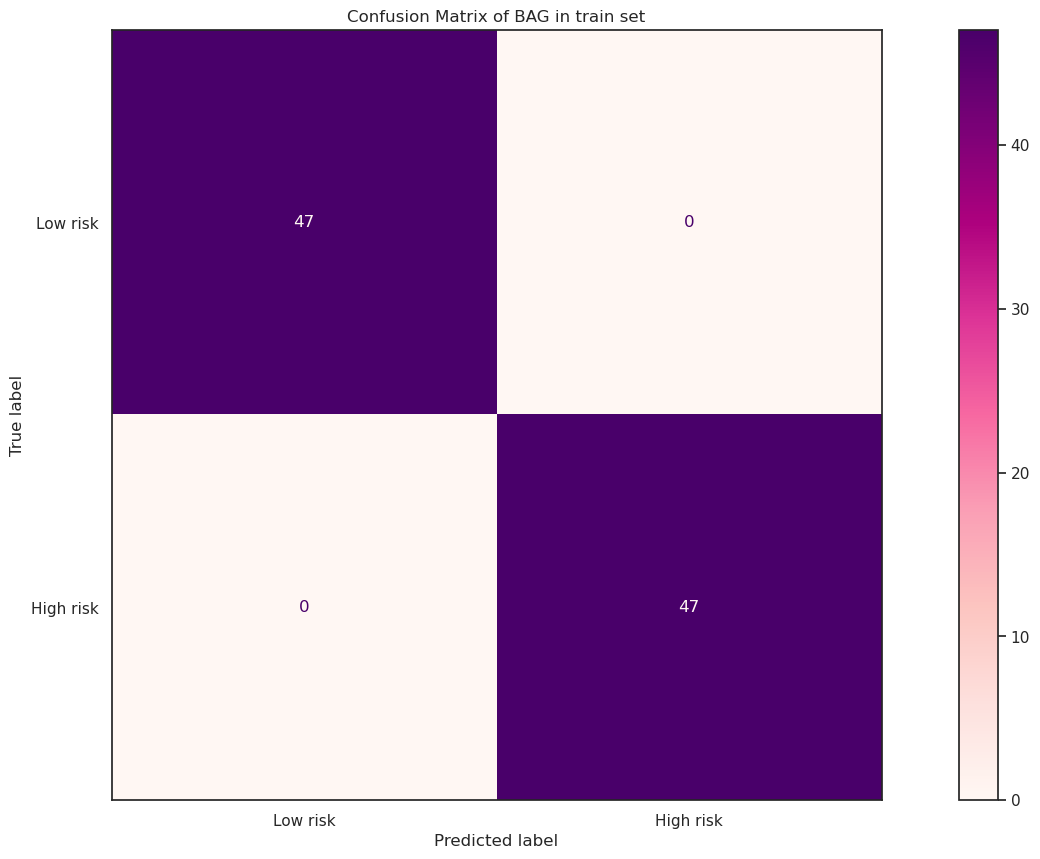

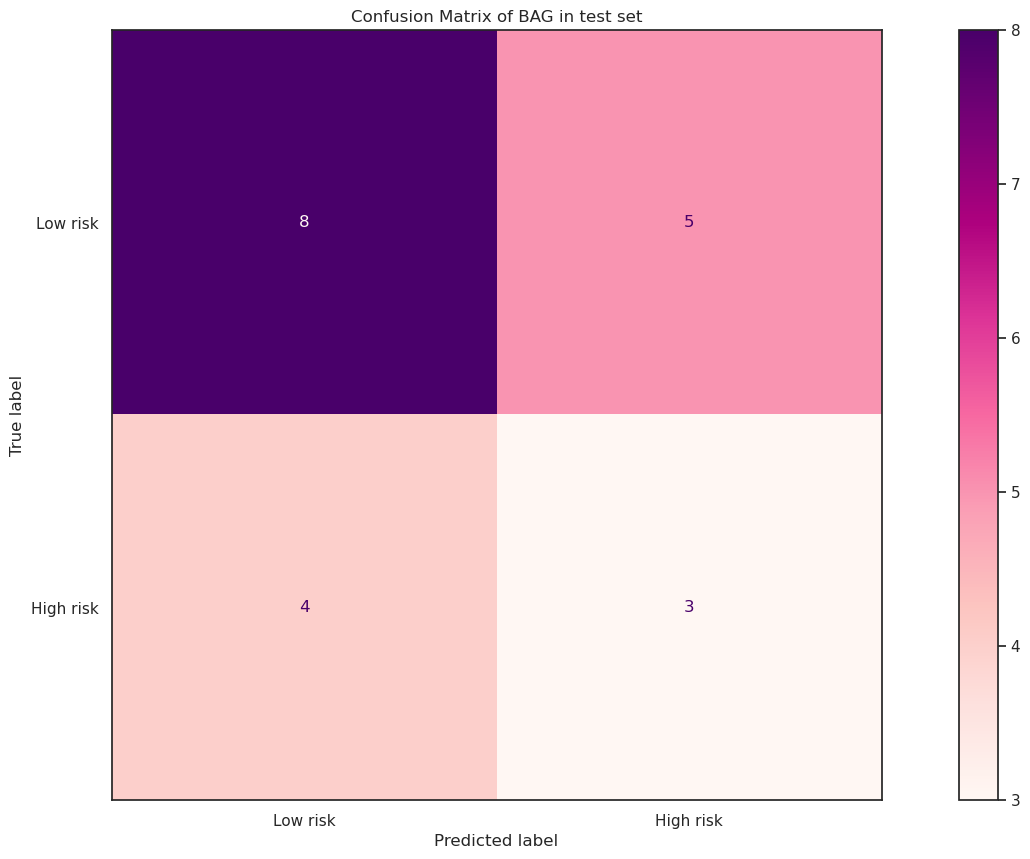

In [17]:
model = RF_model    
  
# 创建一个图形和两个子图  
#训练集
mlp_prob_train = model.predict(X_train)  
cm = confusion_matrix(y_train, mlp_prob_train)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of BAG in train set")
plt.savefig('训练集混淆矩阵.pdf',format='pdf')
plt.show()

#测试集
mlp_prob_test = model.predict(X_test)  
cm = confusion_matrix(y_test, mlp_prob_test)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of BAG in test set")  
plt.savefig('测试集混淆矩阵.pdf',format='pdf') 
plt.show()

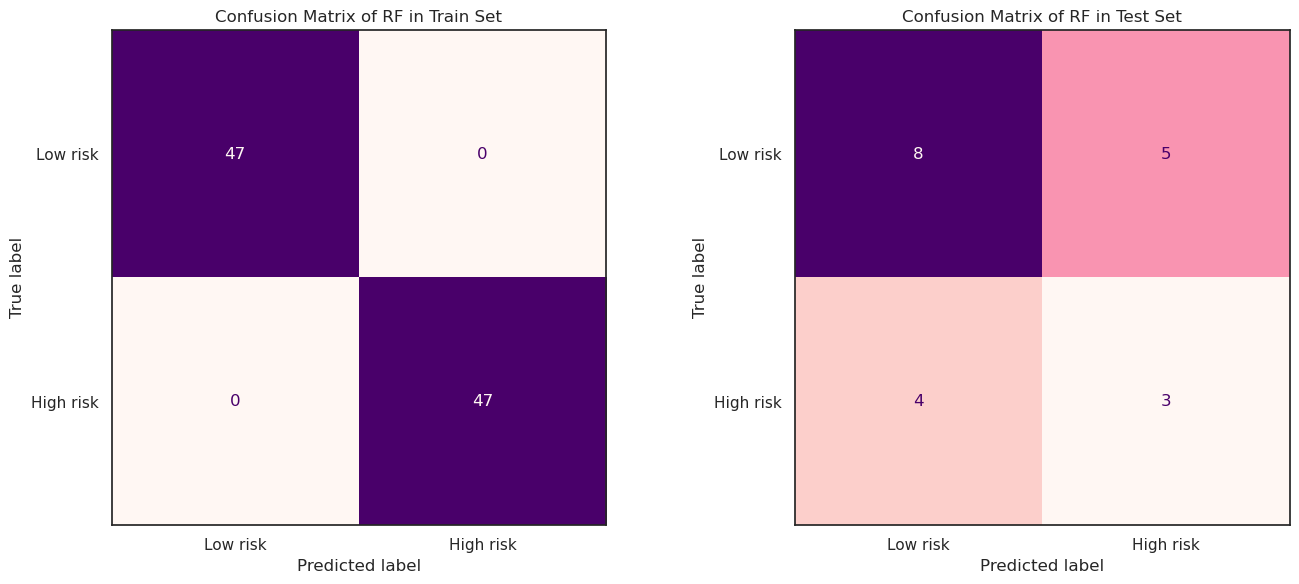

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model
model = RF_model

# Predict on train and test sets
mlp_prob_train = model.predict(X_train)
mlp_prob_test = model.predict(X_test)

# Compute confusion matrices
cm_train = confusion_matrix(y_train, mlp_prob_train)
cm_test = confusion_matrix(y_test, mlp_prob_test)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size as needed

# Set seaborn style
sns.set_style("white")

# Train set confusion matrix (left subplot)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Low risk', 'High risk'])
disp_train.plot(ax=axes[0], cmap='RdPu', colorbar=False)  # Remove colorbar if not needed
axes[0].set_title("Confusion Matrix of RF in Train Set")
axes[0].grid(False)  # Disable gridlines
disp_train.im_.set_interpolation('nearest')  # Remove white cross lines

# Test set confusion matrix (right subplot)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Low risk', 'High risk'])
disp_test.plot(ax=axes[1], cmap='RdPu', colorbar=False)
axes[1].set_title("Confusion Matrix of RF in Test Set")
axes[1].grid(False)  # Disable gridlines
disp_test.im_.set_interpolation('nearest')  # Remove white cross lines

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('训练集-测试集混淆矩阵.pdf', format='pdf')
plt.show()


# 最佳模型五折ROC曲线

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

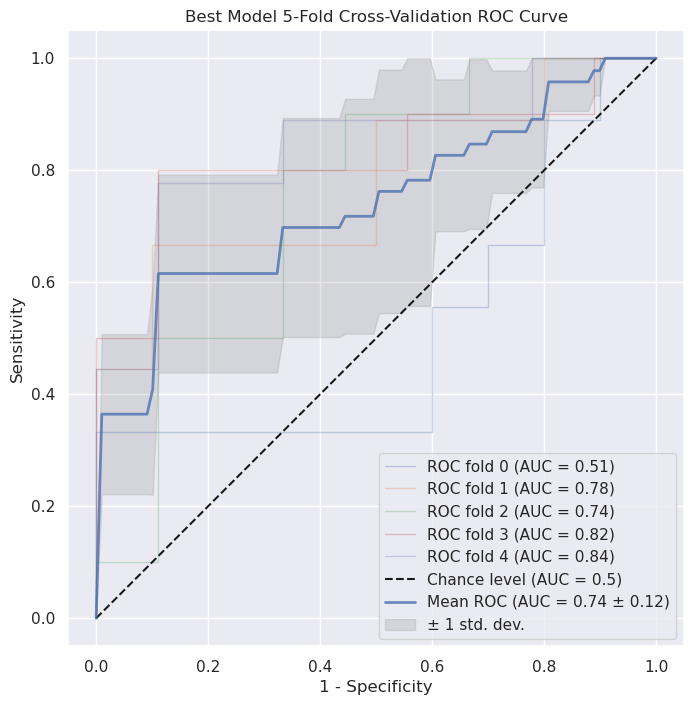

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, RocCurveDisplay

# Set visualization style
sns.set()

# Define 5-fold cross-validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

# Choose the best-performing model
classifier = lr_model  # Modify to the best model

# Prepare for ROC Curve plotting
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Assign training data
X = X_train  # Modify to the corresponding training set
y = y_train

# Create figure for ROC curve
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

# Perform Stratified K-Fold Cross-Validation
for fold, (train, test) in enumerate(cv.split(X, y)):
    # Train model on current fold
    classifier.fit(X.iloc[train], y.iloc[train])
    
    # Plot ROC curve for each fold
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    
    # Interpolate True Positive Rates
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# Compute Mean ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot Mean ROC Curve
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f ± %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# Compute Standard Deviation Range for TPR
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

# Plot Variability Region
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"± 1 std. dev.",
)

# Set Plot Labels and Limits
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Best Model 5-Fold Cross-Validation ROC Curve",  # Modify Title Accordingly
)
ax.legend(loc="lower right")

# Corrected Axis Labels
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")

# Save and Show the Figure
plt.savefig('最佳模型五折ROC曲线.pdf', format='pdf')
plt.show()


# 模型在测试集中的性能展示

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

# Initialize evaluation DataFrame with row names
data_pingjia = pd.DataFrame(index=['F1', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity'])

# Dictionary of models with their respective names
models = {
    "AB": AB_model,
    "LR": lr_model,
    "BAG": Bag_model,
    "MLP": mlp_model,
    "GBM": gbm_model,
    "XGB": xgb_model,
    "NBC": NBC_model,
    "RF": RF_model,
    "SVC": SVC_model
}

# Compute evaluation metrics for each model
for name, model in models.items():
    # Compute F1-score
    f1 = f1_score(y_test, model.predict(X_test), average='macro')
    
    # Compute AUC
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_score = auc(fpr, tpr)
    
    # Compute Accuracy
    accuracy = model.score(X_test, y_test)
    
    # Compute Sensitivity & Specificity
    TN, FP, FN, TP = confusion_matrix(y_test, model.predict(X_test)).ravel()
    sensitivity = round(TP / (TP + FN), 3)
    specificity = round(TN / (FP + TN), 3)
    
    # Store results in DataFrame
    data_pingjia[name] = [f1, auc_score, accuracy, sensitivity, specificity]

# Transpose and round the final evaluation DataFrame
evaluation_metrics = data_pingjia.T.round(3)
evaluation_metrics
# Display results
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Model Evaluation Metrics", dataframe=evaluation_metrics)


,F1,AUC,Accuracy,Sensitivity,Specificity
AB,0.520,0.341,0.55,0.429,0.615
LR,0.583,0.505,0.60,0.571,0.615
BAG,0.520,0.396,0.55,0.429,0.615
MLP,0.394,0.637,0.65,0.000,1.000
GBM,0.451,0.363,0.50,0.286,0.615
XGB,0.520,0.429,0.55,0.429,0.615
NBC,0.467,0.374,0.60,0.143,0.846
RF,0.520,0.412,0.55,0.429,0.615
SVC,0.467,0.352,0.60,0.143,0.846


In [21]:
evaluation_metrics.T

,AB,LR,BAG,MLP,GBM,XGB,NBC,RF,SVC
F1,0.520,0.583,0.520,0.394,0.451,0.520,0.467,0.520,0.467
AUC,0.341,0.505,0.396,0.637,0.363,0.429,0.374,0.412,0.352
Accuracy,0.550,0.600,0.550,0.650,0.500,0.550,0.600,0.550,0.600
Sensitivity,0.429,0.571,0.429,0.000,0.286,0.429,0.143,0.429,0.143
Specificity,0.615,0.615,0.615,1.000,0.615,0.615,0.846,0.615,0.846


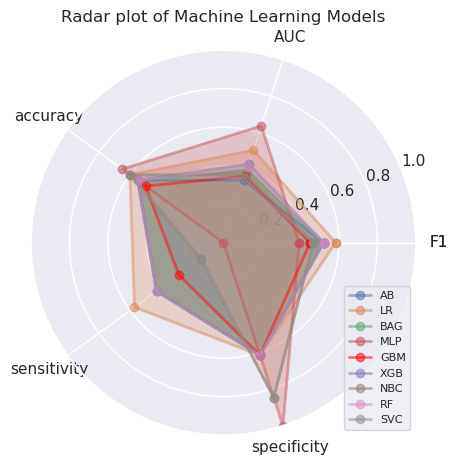

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
values = data_pingjia.AB
values1 = data_pingjia.LR
values2 = data_pingjia.BAG
values3 = data_pingjia.MLP
values4 = data_pingjia.GBM
values5 = data_pingjia.XGB
values6 = data_pingjia.NBC
values7 = data_pingjia.RF
values8 = data_pingjia.SVC

S_labels = ['F1','AUC','accuracy','sensitivity','specificity','F1'] #最后一个一定要与第一个重合0和360的问题

# 设置每个数据点的角度
angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)#2*np.pi是2π的意思

# 拼接数据首尾，使图形中线条封闭
values = np.concatenate((values, [values[0]]))
values1 = np.concatenate((values1, [values1[0]]))
values2 = np.concatenate((values2, [values2[0]]))
values3 = np.concatenate((values3, [values3[0]]))
values4 = np.concatenate((values4, [values4[0]]))
values5 = np.concatenate((values5, [values5[0]]))
values6 = np.concatenate((values6, [values6[0]]))
values7 = np.concatenate((values7, [values7[0]]))
values8 = np.concatenate((values8, [values8[0]]))

angles = np.concatenate((angles, [angles[0]]))

# 绘图
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, polar=True)

# 绘制折线图
ax.plot(angles, values, 'o-', linewidth=2, alpha=0.5, label='AB')
ax.plot(angles, values1, 'o-', linewidth=2, alpha=0.5, label='LR')
ax.plot(angles, values2, 'o-', linewidth=2, alpha=0.5, label='BAG')
ax.plot(angles, values3, 'o-', linewidth=2, alpha=0.5, label='MLP')
ax.plot(angles, values4, 'o-', linewidth=2, alpha=0.5, label='GBM', color='red')
ax.plot(angles, values5, 'o-', linewidth=2, alpha=0.5, label='XGB')
ax.plot(angles, values6, 'o-', linewidth=2, alpha=0.5, label='NBC')
ax.plot(angles, values7, 'o-', linewidth=2, alpha=0.5, label='RF')
ax.plot(angles, values8, 'o-', linewidth=2, alpha=0.5, label='SVC')

# 填充颜色
ax.fill(angles, values, alpha=0.25)
ax.fill(angles, values1, alpha=0.25)
ax.fill(angles, values2, alpha=0.25)
ax.fill(angles, values3, alpha=0.25)
ax.fill(angles, values4, alpha=0.25)
ax.fill(angles, values5, alpha=0.25)
ax.fill(angles, values6, alpha=0.25)
ax.fill(angles, values7, alpha=0.25)
ax.fill(angles, values8, alpha=0.25)

# 设置标签
ax.set_thetagrids(angles * 180/np.pi, labels=S_labels)#angles * 180/np.pi 将弧度转化为度数
ax.set_ylim(0, 1)
plt.title('Radar plot of Machine Learning Models')

# 调整图例位置
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=8, frameon=True)

# 添加网格线
ax.grid(True)

# 保存图像
plt.savefig('01.TR-模型在测试集中的性能展示-雷达图.pdf', format='pdf', bbox_inches='tight')
plt.show()


# 特征重要性SHAP-Perumation

In [59]:
import shap

# 解释器使用 KernelExplainer
explainer = shap.KernelExplainer(Bag_model.predict, X_train)
# 计算 SHAP 值
shap_values = explainer.shap_values(X_train)

  0%|          | 0/94 [00:00<?, ?it/s]

In [13]:
y_train.iloc[150, :]

IndexingError: Too many indexers

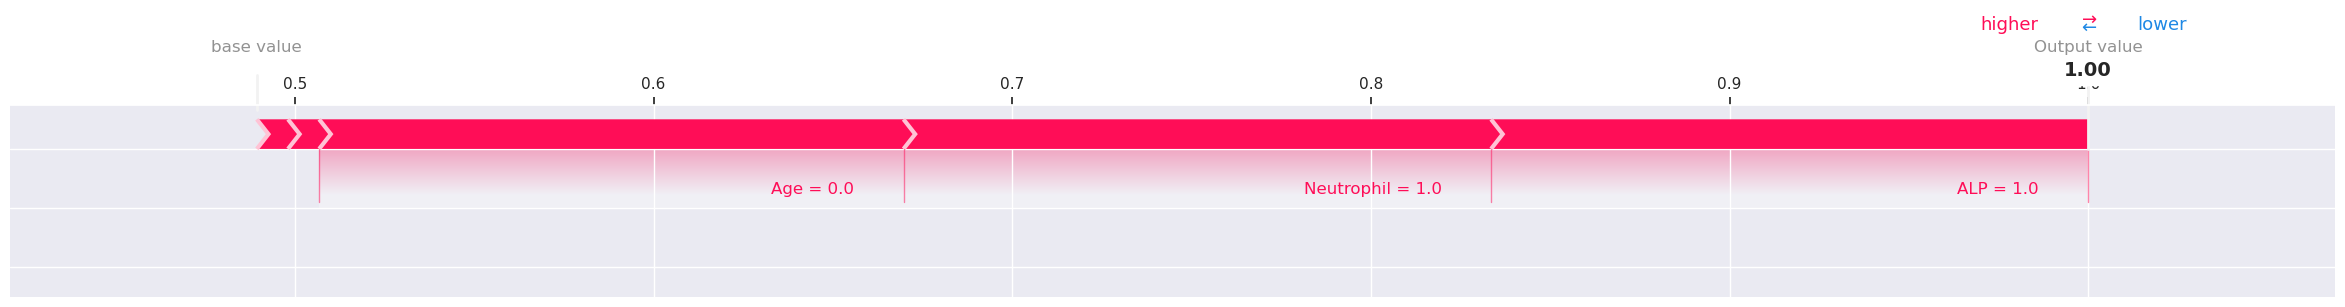

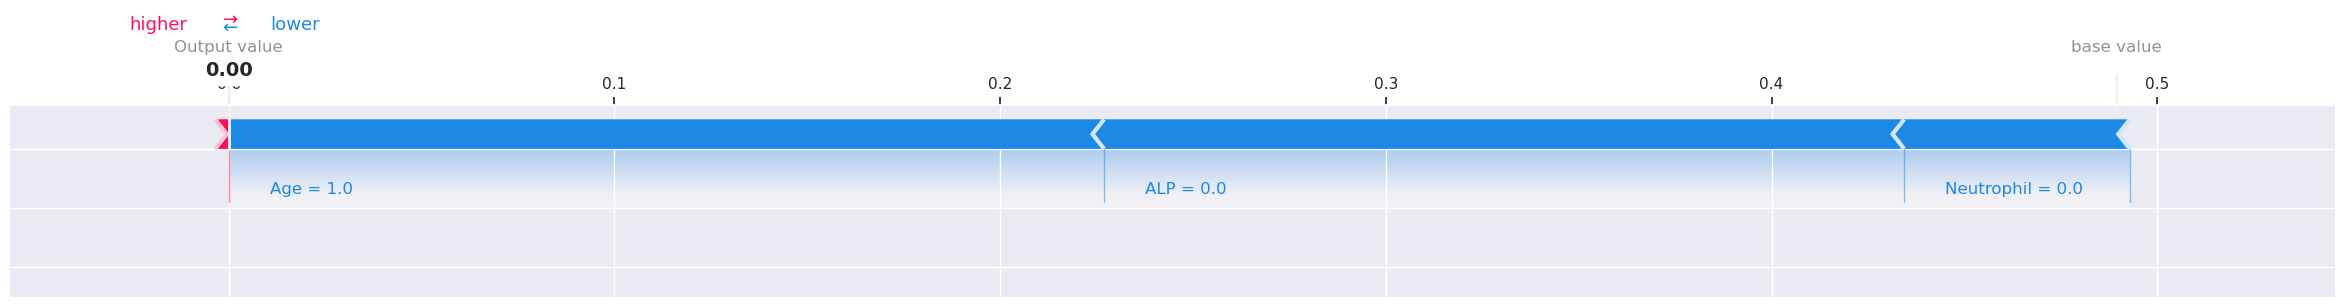

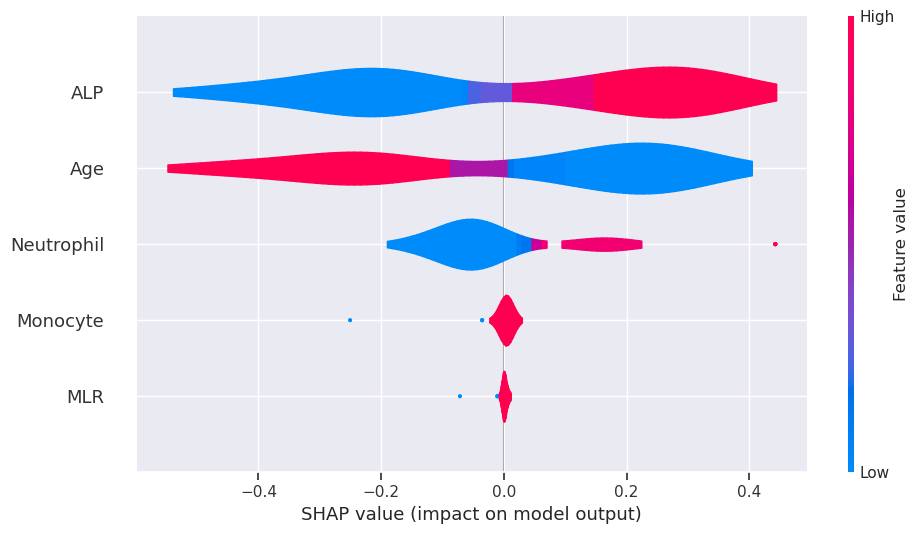

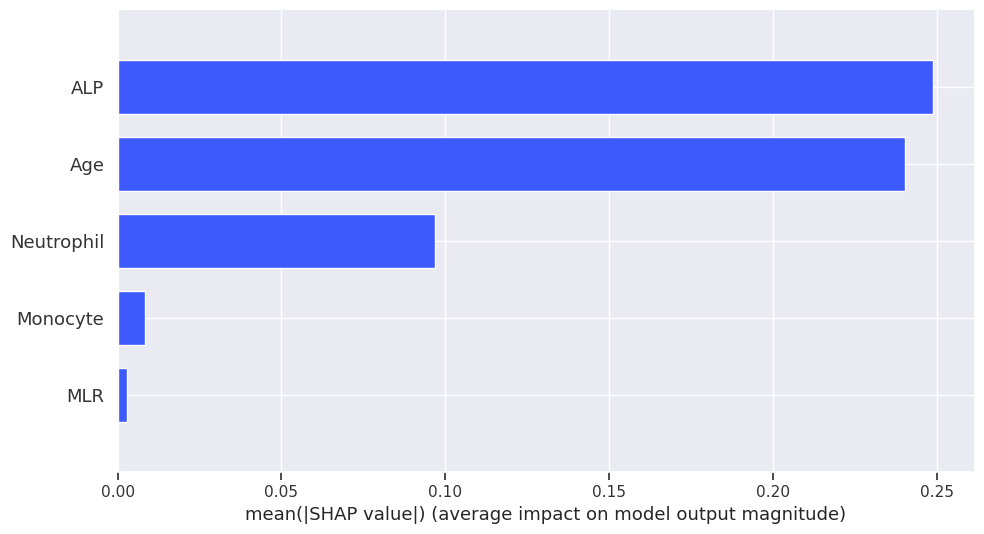

In [61]:


# 可视化第一个预测的 SHAP 值
#shap.force_plot(explainer.expected_value, shap_values[0], X_test[0])
#explainer = shap.Explainer(Mlp_model,X_train)
#shap_values = explainer(X_train)

#吴世楠绘制
#Feature importances1 and 2
a = 80
shap.plots.force(explainer.expected_value,  #shap.force_plot
                shap_values[a],  #表示第 155 个样本的特征对模型输出的影响(低风险强脊)
                X_train.iloc[a, :], 
                figsize=(30, 2.5),
                #link = "logit",
                matplotlib=True,
                out_names = "Output value",show=False)
#plt.rcParams["figure.figsize"] = [30, 5]
plt.savefig('plot1.png',format='png')
plt.show()

a = 20
shap.plots.force(explainer.expected_value,  #shap.force_plot
                shap_values[a], 
                X_train.iloc[a, :], 
                figsize=(30, 2.5),
                # link = "logit",
                matplotlib=True,
                out_names = "Output value",show=False)
#plt.rcParams["figure.figsize"] = [30, 10]
plt.savefig('plot2.pdf',format='pdf')
plt.show()

#Feature importances(吴世楠)
#violin
shap.summary_plot(shap_values, 
                  X_train,
                  plot_type="violin", 
                  max_display=10,
                  color='#3d5afe',
                  title='Feature importance',show=False,plot_size=(10,5.5))
# plt.title("Feature importance")
plt.savefig('violin.pdf',format='pdf')
plt.show()

#bar
shap.summary_plot(shap_values, 
                  X_train, 
                  plot_type="bar", 
                  color='#3d5afe',
                  title='Feature importance',max_display=10,show=False,plot_size=(10,5.5))
# plt.title("Feature importance")
plt.savefig('bar.pdf',format='pdf')
plt.show()

# ##Feature importances(刘文彩)
# shap.bar_plot(shap_values, features=None, feature_names=None, max_display=10, show=False)
# plt.title("Feature importance")
# plt.show()

In [62]:
result = permutation_importance(AB_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result1 = permutation_importance(lr_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result2= permutation_importance(Bag_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result3 = permutation_importance(mlp_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result4 = permutation_importance(gbm_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result5 = permutation_importance(xgb_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result6 = permutation_importance(NBC_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result7 = permutation_importance(RF_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result8 = permutation_importance(SVC_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')


plt.rcParams["figure.figsize"] = [30, 15]
features = X.columns

plt.subplot(331)
r_feat_imp = pd.Series(abs(100*(result.importances_mean)/result.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of AB',color='#5fc9f8')
# 只取前15个最重要的特征  
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True) 
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of AB',color='#5fc9f8')


plt.subplot(332)
r_feat_imp = pd.Series(abs(100*result1.importances_mean/result1.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of LR',color='#fecb2e')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of LR',color='#fecb2e')

plt.subplot(333)
r_feat_imp = pd.Series(abs(100*result2.importances_mean/result2.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of BAG',color='#fd9426')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of BAG',color='#fd9426')

plt.subplot(334)
r_feat_imp = pd.Series(abs(100*result3.importances_mean/result3.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of MLP',color='#fc3158')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of MLP',color='#fc3158')

plt.subplot(335)
r_feat_imp = pd.Series(abs(100*result4.importances_mean/result4.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of GBM',color='#147efb')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of GBM',color='#147efb')

plt.subplot(336)
r_feat_imp = pd.Series(abs(100*result5.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')

plt.subplot(337)
r_feat_imp = pd.Series(abs(100*result6.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of NBC',color='#cb00f5')

plt.subplot(338)
r_feat_imp = pd.Series(abs(100*result7.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of RF',color='#53fe5c')

plt.subplot(339)
r_feat_imp = pd.Series(abs(100*result8.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of SVC',color='#fff917')

plt.savefig('feature_importances.pdf', format='pdf')  

plt.close()


# 模型导出

In [65]:
import joblib

# 将模型保存为文件
joblib.dump(Bag_model,'Bag_model.pkl')

['Bag_model.pkl']

In [24]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# 加载模型
model = joblib.load('xgb_model.pkl')

# 定义预测接口
@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    features = data['features']
    prediction = model.predict(features)
    return jsonify({'prediction': prediction.tolist()})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (inotify)
Traceback (most recent call last):
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipyke

SystemExit: 1

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
